In [1]:
from cil.framework import ImageGeometry
from cil.utilities.jupyter import islicer
from cil.utilities.display import show2D, show1D, show_geometry
from cil.processors import CentreOfRotationCorrector, TransmissionAbsorptionConverter, RingRemover, Padder, Slicer
from cil.recon import FBP
from cil.io import NEXUSDataWriter
from cil.io.utilities import HDF5_utilities
import numpy as np
import os
import hdf5plugin
from cil.framework import AcquisitionGeometry, AcquisitionData
import matplotlib.pyplot as plt
from tomopy.prep.phase import retrieve_phase

/home/bgb37495/miniconda3/envs/cil_esrf/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
filename = '/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'#
angles = HDF5_utilities.read(filename, '/4.1/measurement/hrsrot')
ds_metadata = HDF5_utilities.get_dataset_metadata(filename, '4.1/instrument/pco2linux/data')

In [3]:
roi = [slice(None), slice(450, 950), slice(None)]
source_sel=tuple(roi)

In [4]:
filename = '/data/ESRF/Wedgescan_Iterative_ASSB/flats.h5'#
HDF5_utilities.print_metadata(filename, '/entry_0000/measurement', 2)
HDF5_utilities.get_dataset_metadata(filename, 'entry_0000/measurement/data')
flats = HDF5_utilities.read(filename, 'entry_0000/measurement/data', tuple(source_sel))
flat = np.mean(flats, axis = 0) #median?


filename = '/data/ESRF/Wedgescan_Iterative_ASSB/darks.h5'#
HDF5_utilities.print_metadata(filename, 'entry_0000/measurement', 2)
HDF5_utilities.get_dataset_metadata(filename, 'entry_0000/measurement/data')
darks = HDF5_utilities.read(filename, 'entry_0000/measurement/data', tuple(source_sel))
dark = np.mean(darks, axis = 0) 

	 - data : <HDF5 dataset "data": shape (60, 2160, 2560), type "<i4">
			 - interpretation : image
	 - data : <HDF5 dataset "data": shape (20, 2160, 2560), type "<i4">
			 - interpretation : image


In [47]:
projections = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
data = np.empty((3000, roi[1].stop-roi[1].start, ds_metadata['shape'][2]), dtype=np.float32)
for i in projections:
    filename = '/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_{0:04}.h5'.format(i)
    print(filename)
    ds_arr = HDF5_utilities.read_to(filename, 'entry_0000/measurement/data',data,source_sel, np.s_[i*200:i*200+200,:,:])
    # ds_arr[ds_arr>1000] = np.mean(ds_arr) ### this isn't right - how should I be doing this?
    #data[i*200:i*200+200] = ds_arr
flat = flat - dark
data = (data - dark)/ flat

/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0000.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0001.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0002.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0003.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0004.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0005.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0006.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0007.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0008.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0009.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0010.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0011.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0012.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0013.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0014.h5


In [48]:
ag = AcquisitionGeometry.create_Parallel3D().set_panel([np.shape(data)[2],np.shape(data)[1]]).set_angles(angles)
data = AcquisitionData(data, deep_copy=False, geometry = ag)

In [49]:
data = Slicer(roi={'angle': (300, 2710, 1)})(data)
# islicer(data, direction='vertical')

In [50]:
processor = TransmissionAbsorptionConverter()
processor.set_input(data)
processor.get_output(out=data)
# show2D(data)

In [51]:
gradient = 0
offset = 0
mean_intensity = 0
for i in np.arange(data.shape[0]):
    y = data.array[i,int(data.shape[1]/2),:]
    x = np.arange(len(y))
    coef = np.polyfit(x,y,1)
    gradient += coef[0]
    offset += coef[1]
    mean_intensity += np.mean(data.array[i,:,:])
    poly1d_fn = np.poly1d(coef)

gradient = gradient/data.shape[0]
offset = offset/data.shape[0]
mean_intensity = mean_intensity/data.shape[0]
poly1d_fn = np.poly1d([gradient, offset])

for i in np.arange(data.shape[0]):
    proj_index = i
    data.array[i,:,:] = data.array[i,:,:] / poly1d_fn(x)
data.array[:,:,:] = mean_intensity*data.array[:,:,:]/np.mean(data.array[:,:,:])



In [56]:
data_phase = retrieve_phase(data.array, alpha=0.01)
data = AcquisitionData(data_phase, deep_copy=False, geometry = data.geometry)

In [57]:
# slice
vertical = 400
data_slice = data.get_slice(vertical=vertical)
ig = data_slice.geometry.get_ImageGeometry()
padsize = 3000
data_slice = Padder.linear_ramp(padsize, 0)(data_slice)
r = RingRemover(8,'db20', 1.5)
r.set_input(data_slice)
data_slice = r.get_output()
data_slice.geometry.set_centre_of_rotation(16.5, distance_units='pixels')


Finish Ring Remover


FBP recon

Input Data:
	angle: 2410
	horizontal: 8560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 15
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



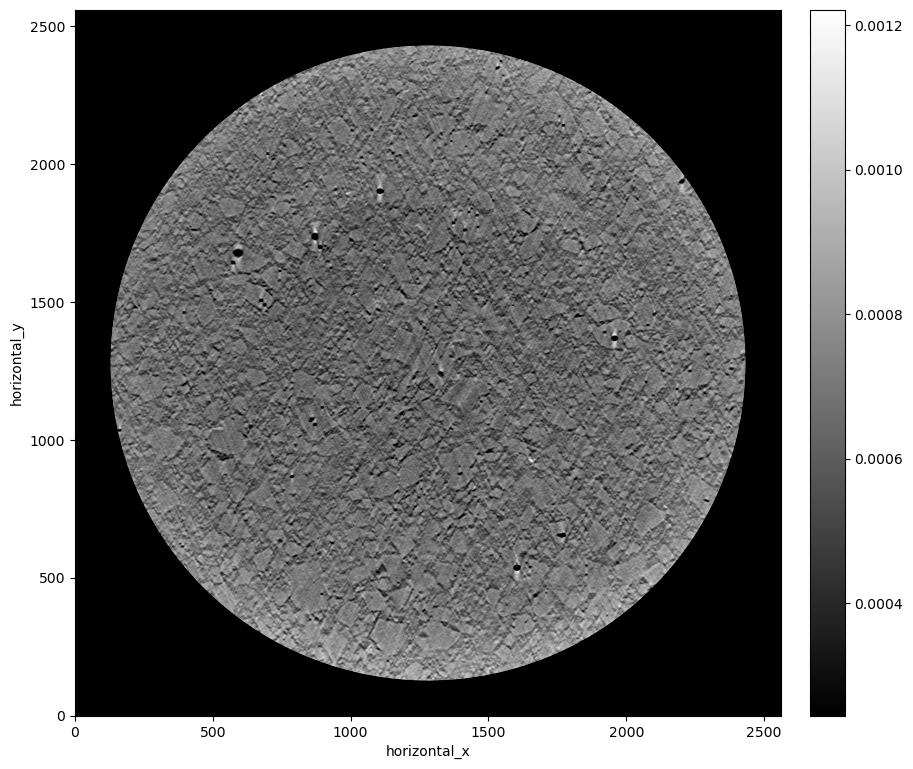

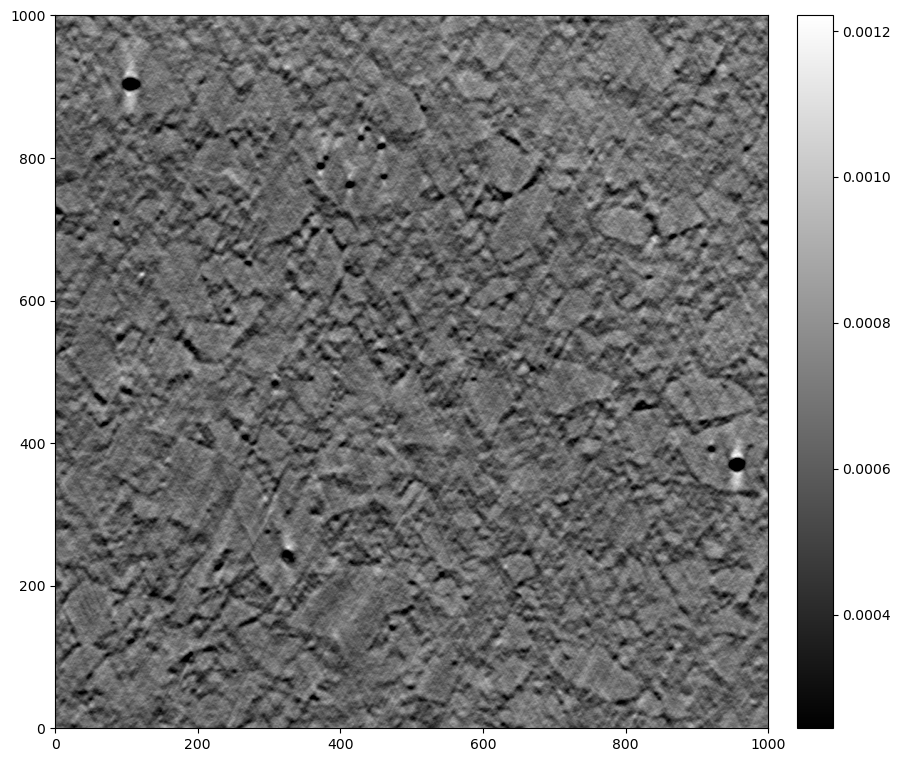

In [121]:
reco_FBP = FBP(data_slice, ig).run()
reco_FBP.apply_circular_mask(0.9)
show2D(reco_FBP, fix_range=(reco_FBP.max()*0.9, reco_FBP.max()*0.2))
show2D(reco_FBP.array[1000:2000,1000:2000],  fix_range=(reco_FBP.max()*0.9, reco_FBP.max()*0.2))

In [59]:
from cil.optimisation.functions import L2NormSquared, BlockFunction, L1Norm, ZeroFunction, MixedL21Norm, IndicatorBox, TotalVariation
from cil.optimisation.algorithms import PDHG
from cil.optimisation.operators import BlockOperator, FiniteDifferenceOperator, GradientOperator
from cil.plugins.astra.operators import ProjectionOperator

In [63]:
def algo_anisotropic_TV(data_slice, scale_x=0, scale_y=0, initial=None):

    ag = data_slice.geometry
    ig = ag.get_ImageGeometry()
    F = BlockFunction(L2NormSquared(b=data_slice), 
                    L1Norm(),
                    L1Norm())

    A = ProjectionOperator(ig, ag, device="gpu")
    Dx = FiniteDifferenceOperator(ig, direction='horizontal_x')
    Dy = FiniteDifferenceOperator(ig, direction='horizontal_y')
    ratio_x = A.norm()/Dx.norm()
    alpha_x = ratio_x*scale_x
    ratio_y = A.norm()/Dy.norm()
    alpha_y = ratio_y*scale_y
    K = BlockOperator(A, 
                    alpha_x*Dx,
                    alpha_y*Dy)
    
    G = ZeroFunction()

    normK = K.norm()
    sigma = 0.5
    tau = 1./(sigma*normK**2)

    myPDHG = PDHG(f=F, 
                g=G, 
                operator=K, 
                sigma = sigma, tau = tau,
                initial = initial,
                max_iteration=2000, 
                update_objective_interval = 10,
                )
    
    return myPDHG

In [64]:
def algo_isotropic_TV(data_slice, alpha, initial=None):

    ag = data_slice.geometry
    ig = ag.get_ImageGeometry()

    F = BlockFunction(alpha * MixedL21Norm(),
        0.5*L2NormSquared(b=data_slice))

    K = BlockOperator(GradientOperator(ig), 
                      ProjectionOperator(ig, ag, device="gpu"))
    
    G = IndicatorBox(lower=0)

    normK = K.norm()
    sigma = 0.5
    tau = 1./(sigma*normK**2)

    myPDHG = PDHG(f=F, 
                g=G, 
                operator=K, 
                sigma = sigma, tau = tau,
                initial = initial,
                max_iteration=2000, 
                update_objective_interval = 10,
                )
    
    return myPDHG

In [65]:
def algo_isotropic_TV_implicit(data_slice, alpha, initial=None):

    ag = data_slice.geometry
    ig = ag.get_ImageGeometry()

    F = 0.5 * L2NormSquared(b=data_slice)
    
    G = (alpha/ig.voxel_size_y) *TotalVariation(max_iteration=10)
    
    K = ProjectionOperator(ig, ag, device='gpu')

    normK = K.norm()
    sigma = 0.5
    tau = 1./(sigma*normK**2)

    myPDHG = PDHG(f=F, 
                g=G, 
                operator=K, 
                sigma = sigma, tau = tau,
                initial = initial,
                max_iteration=2000, 
                update_objective_interval = 10,
                )
    
    return myPDHG

In [ ]:
myPDHG1 = algo_isotropic_TV_implicit(data_slice, alpha=0.5, initial=None)
myPDHG1.run(100,verbose=2)
reco1 = myPDHG1.solution

reco1 = Slicer(roi={'horizontal_y': (3000,5560), 'horizontal_x' : (3000,5560)})(reco1)
writer = NEXUSDataWriter()
writer.set_up(data=reco1,
        file_name='prephase_reco_alpha_05.nxs')
writer.write()

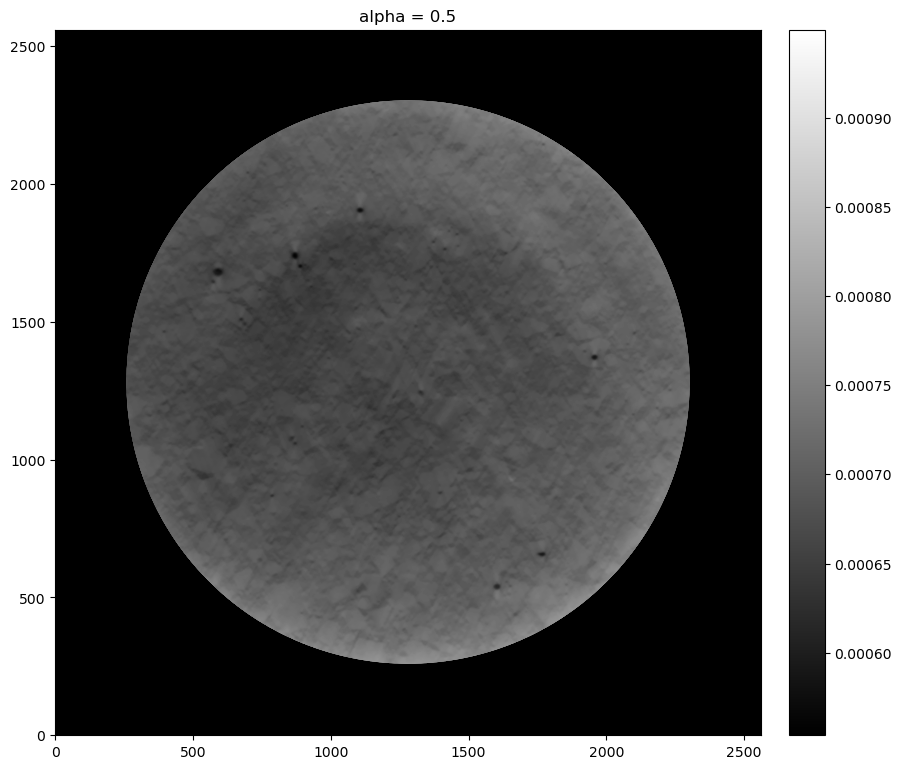

In [114]:
reco1.apply_circular_mask(0.9)
show2D(reco1.array, title='alpha = 0.5', fix_range=(reco1.max()*0.7, reco1.max()*1.2))

In [ ]:
myPDHG2 = algo_isotropic_TV_implicit(data_slice, alpha=1.0, initial=None)
myPDHG2.run(100,verbose=2)
reco2 = myPDHG2.solution

reco2 = Slicer(roi={'horizontal_y': (3000,5560), 'horizontal_x' : (3000,5560)})(reco2)
writer = NEXUSDataWriter()
writer.set_up(data=reco2,
        file_name='prephase_reco_alpha_1.nxs')
writer.write()



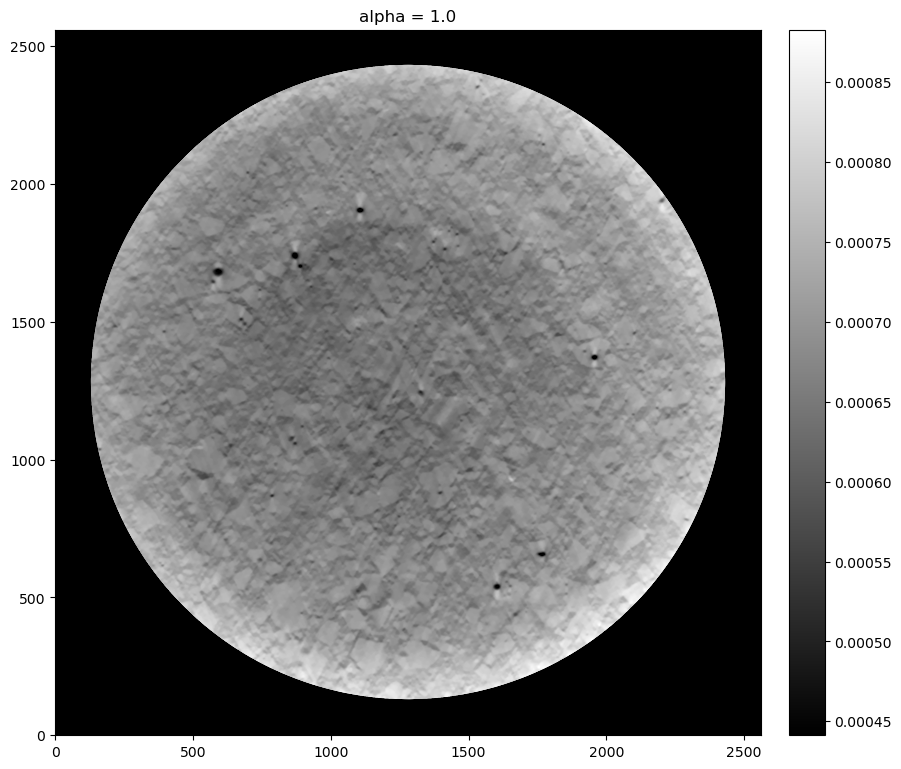

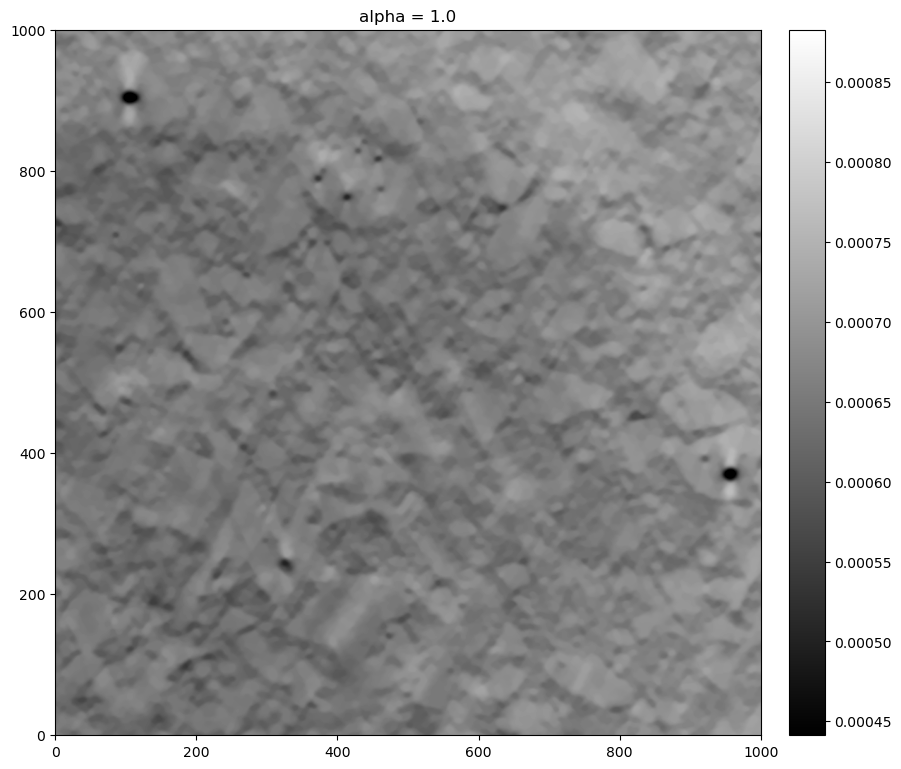

In [117]:
reco2.apply_circular_mask(0.9)
show2D(reco2.array, title='alpha = 1.0', fix_range=(reco2.max()*0.5, reco2.max()*1))
show2D(reco2.array[1000:2000,1000:2000], title='alpha = 1.0', fix_range=(reco2.max()*0.5, reco2.max()*1))

In [ ]:
myPDHG3 = algo_isotropic_TV_implicit(data_slice, alpha=0.1, initial=None)
myPDHG3.run(100,verbose=2)
reco3 = myPDHG3.solution

reco3 = Slicer(roi={'horizontal_y': (3000,5560), 'horizontal_x' : (3000,5560)})(reco3)
writer = NEXUSDataWriter()
writer.set_up(data=reco3,
        file_name='prephase_reco_alpha_01.nxs')
writer.write()



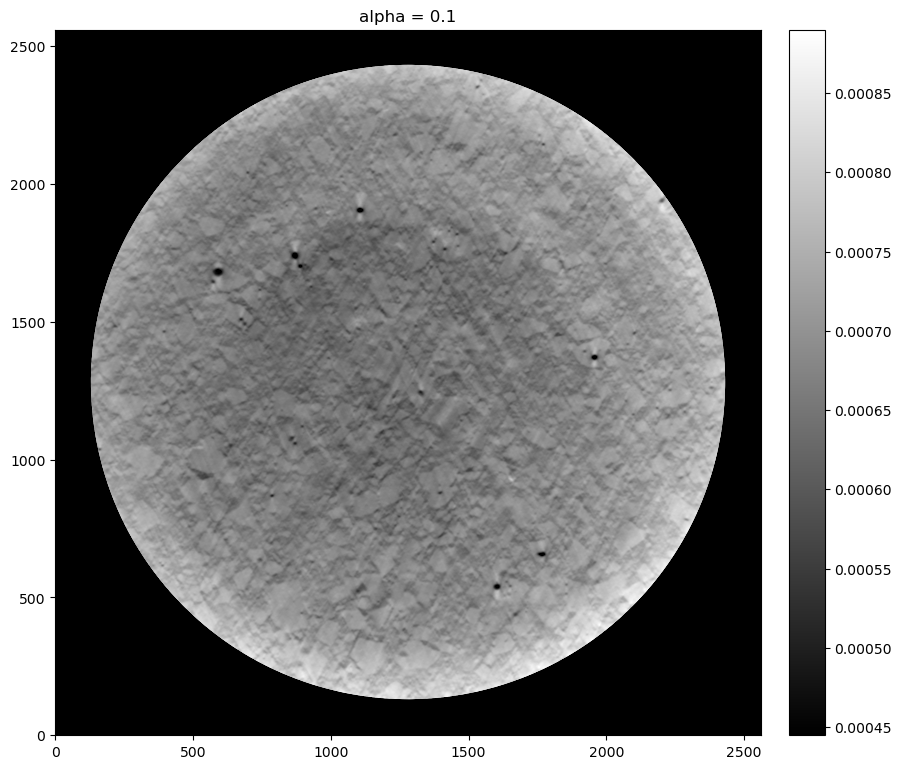

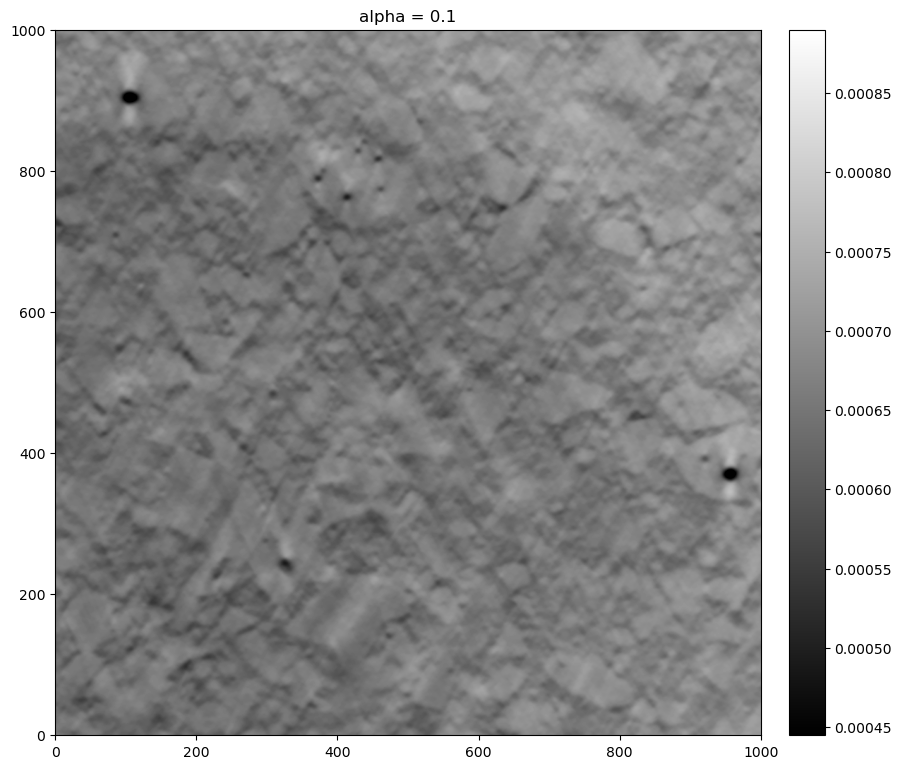

In [119]:
reco3.apply_circular_mask(0.9)
show2D(reco3.array, title='alpha = 0.1', fix_range=(reco3.max()*0.5, reco3.max()*1))
show2D(reco3.array[1000:2000,1000:2000], title='alpha = 0.1', fix_range=(reco3.max()*0.5, reco3.max()*1))

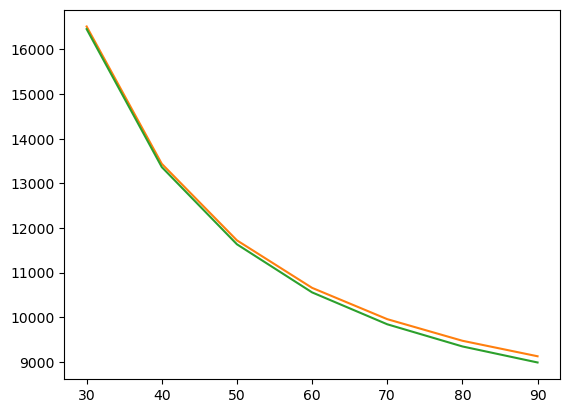

In [135]:
plt.plot(30+np.arange(len(myPDHG1.objective[3:-1]))*10, myPDHG1.objective[3:-1])
plt.plot(30+np.arange(len(myPDHG2.objective[3:-1]))*10, myPDHG2.objective[3:-1])
plt.plot(30+np.arange(len(myPDHG3.objective[3:-1]))*10, myPDHG3.objective[3:-1])



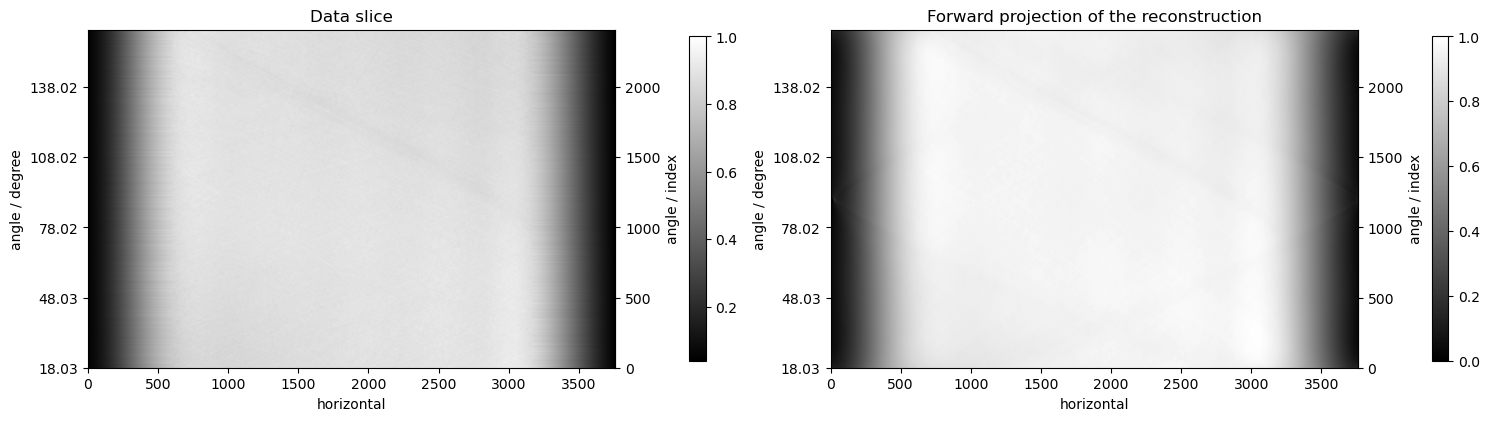

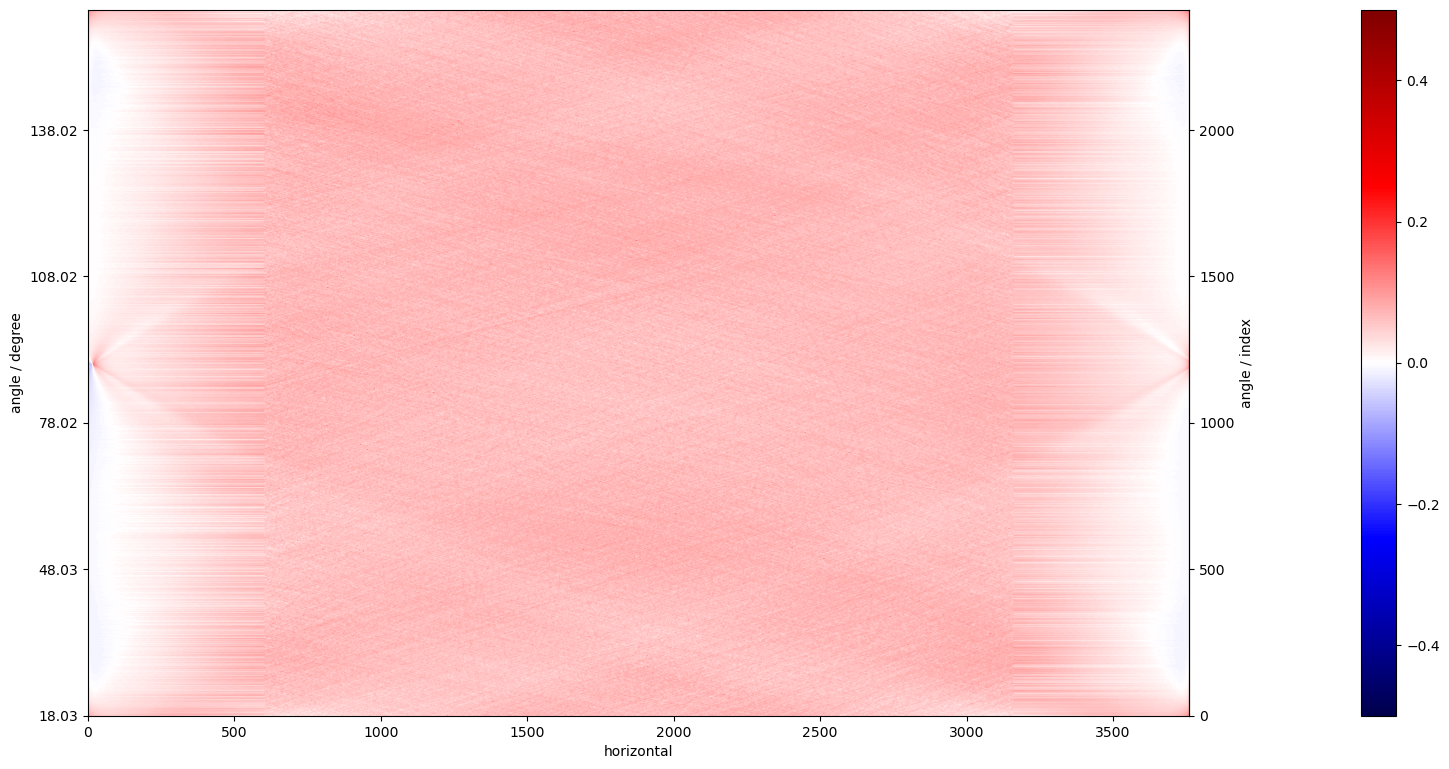

In [56]:
forward_projection = ProjectionOperator(reco.geometry, data_slice.geometry).direct(reco)
residuals = forward_projection/np.max(forward_projection) - data_slice/np.max(data_slice)


show2D([data_slice/np.max(data_slice), forward_projection/np.max(forward_projection)],title=['Data slice', 'Forward projection of the reconstruction'])
show2D(residuals, fix_range = (-0.5, 0.5), cmap='seismic')

In [ ]:
from cil.plugins.astra import FBP

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    3.33900e+06  -0.00000e+00    3.33900e+06
       10       1000         1.782    5.87173e+05  -1.23055e+09    1.23113e+09
       20       1000         1.786    5.08073e+05  -7.34880e+08    7.35389e+08
       30       1000         1.792    4.28042e+05  -5.38128e+08    5.38557e+08
       40       1000         1.789    3.66870e+05  -4.24431e+08    4.24798e+08
       50       1000         1.790    3.14002e+05  -3.56187e+08    3.56501e+08
----------------------------------------------------------------------------
       50       1000         1.790    3.14002e+05  -3.56187e+08    3.56501e+08
Stop criterion has been reached.



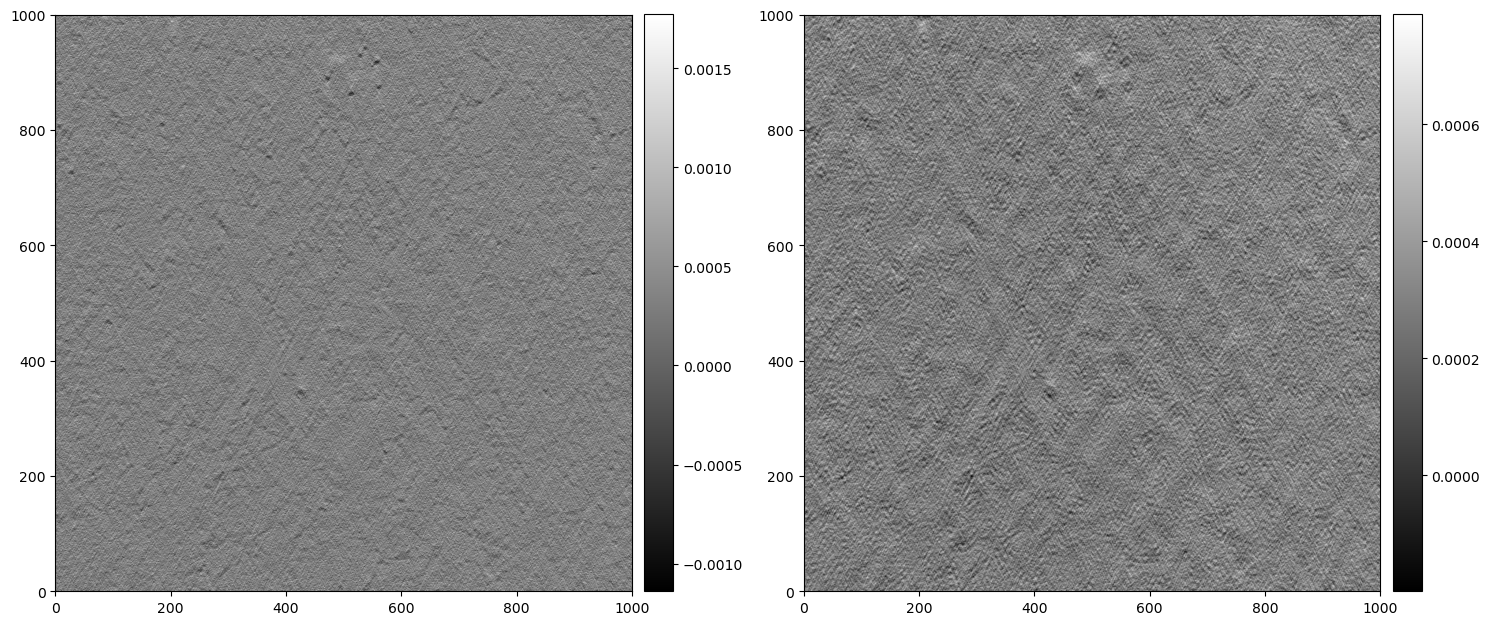

In [ ]:
data_phase = data_slice.array.reshape(data_slice.shape + (1,))
alpha = 0.005
data_phase = retrieve_phase(data_phase, pixel_size=6.5e-4, dist=30, energy=19,  alpha=alpha)
data_phase = data_phase.squeeze()
data_phase = AcquisitionData(data_phase, deep_copy=False, geometry = data_slice.geometry)

# reco_phase_FBP = FBP(data_phase, ig_prepad, backend='astra').run()
reco_phase_FBP = FBP(ig, ag, device='gpu')(data_phase)
reco_phase_FBP = Padder.constant( padsize, float(reco_phase_FBP.mean()))(reco_phase_FBP)
reco_phase = algo(data_phase, initial=reco_phase_FBP)

show2D([reco_phase_FBP.array[1500:2500,1500:2500], reco_phase.array[1500:2500,1500:2500]])

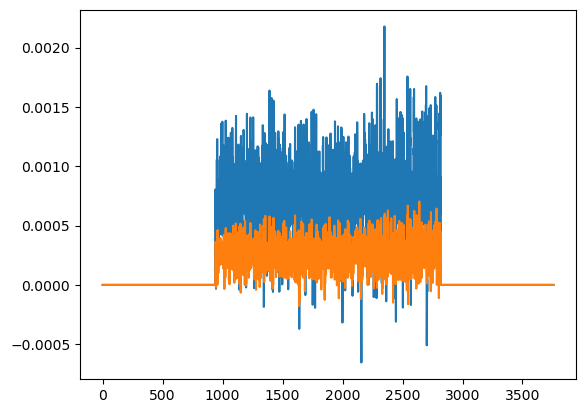

In [ ]:
plt.plot(reco.array[:,int(reco.shape[0]/2)])
plt.plot(reco_phase.array[:,int(reco.shape[0]/2)])